# Model Building

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from helpers import constants as C

In [2]:
df = pd.read_csv("data/processed/Gurgaon/res_apartment.csv")
print(df.shape)
df.head()

(4049, 20)


,PROP_ID,CITY,PRICE,AREA,PROP_HEADING,DESCRIPTION,PROPERTY_TYPE,FURNISH,FACING,AGE,BEDROOM_NUM,PROP_NAME,BALCONY_NUM,FLOOR_NUM,LATITUDE,LONGITUDE,LOCALITY_NAME,SOCIETY_NAME,ADDRESS,LUXURY_CATEGORY
0,d68894450,gurgaon,1100000.0,10777.0,5 bhk flat in sector 42 gurgaon,a 4 bhk duplex flat for rent in sector 42 gurg...,residential apartment,Furnished,North-East,5-10 Year Old Property,5.0,dlf the magnolias,4.0,low rise,28.454897,77.105367,sector 42 gurgaon,dlf the magnolias,a 209,2.0
1,y70794212,gurgaon,1775000.0,600.0,1 bhk flat in sector 95 gurgaon,"ramsons kshitij , sector 95 imt manesar, main ...",residential apartment,Semifurnished,East,1-5 Year Old Property,1.0,ramsons kshitij,1.0,low rise,28.416679,76.902677,sector 95 gurgaon,ramsons kshitij,216,0.0
2,s70190322,gurgaon,2000000.0,366.0,1 bhk flat in sector 95 gurgaon,"situated in sector 95 gurgaon, rof ananda is a...",residential apartment,Unfurnished,North-East,1-5 Year Old Property,1.0,rof ananda,1.0,low rise,28.484814,77.080853,sector 95 gurgaon,rof ananda,405,0.0
3,c64640776,gurgaon,2033000.0,555.0,2 bhk flat in sector 86 gurgaon,check out this 2 bhk apartment for sale in gls...,residential apartment,Semifurnished,East,Under Construction,2.0,gls avenue 86,2.0,mid rise,28.401966,76.942206,sector 86 gurgaon,gls avenue 86,301,2.0
4,f70190474,gurgaon,2050000.0,366.0,1 bhk flat in sector 95 gurgaon,located in the popular residential address of ...,residential apartment,Semifurnished,North-East,1-5 Year Old Property,1.0,rof ananda,1.0,mid rise,28.484814,77.080853,sector 95 gurgaon,rof ananda,509,0.0


In [3]:
df.isnull().sum()

PROP_ID               0
CITY                  0
PRICE                 0
AREA                  0
PROP_HEADING          0
DESCRIPTION           0
PROPERTY_TYPE         0
FURNISH               0
FACING                0
AGE                   0
BEDROOM_NUM           0
PROP_NAME             0
BALCONY_NUM           0
FLOOR_NUM             0
LATITUDE              0
LONGITUDE             0
LOCALITY_NAME         0
SOCIETY_NAME          0
ADDRESS            2122
LUXURY_CATEGORY       0
dtype: int64

In [4]:
target = "PRICE"
num_cols = [
    "AREA",
]
cat_cols = [
    "FURNISH",
    "AGE",
    "BEDROOM_NUM",
    "BALCONY_NUM",
    "FLOOR_NUM",
    "FACING",
    "LOCALITY_NAME",
]

In [5]:
main_df = df[[target] + num_cols + cat_cols].copy(True)
print(main_df.shape)
main_df.head()

(4049, 9)


,PRICE,AREA,FURNISH,AGE,BEDROOM_NUM,BALCONY_NUM,FLOOR_NUM,FACING,LOCALITY_NAME
0,1100000.0,10777.0,Furnished,5-10 Year Old Property,5.0,4.0,low rise,North-East,sector 42 gurgaon
1,1775000.0,600.0,Semifurnished,1-5 Year Old Property,1.0,1.0,low rise,East,sector 95 gurgaon
2,2000000.0,366.0,Unfurnished,1-5 Year Old Property,1.0,1.0,low rise,North-East,sector 95 gurgaon
3,2033000.0,555.0,Semifurnished,Under Construction,2.0,2.0,mid rise,East,sector 86 gurgaon
4,2050000.0,366.0,Semifurnished,1-5 Year Old Property,1.0,1.0,mid rise,North-East,sector 95 gurgaon


<Axes: >

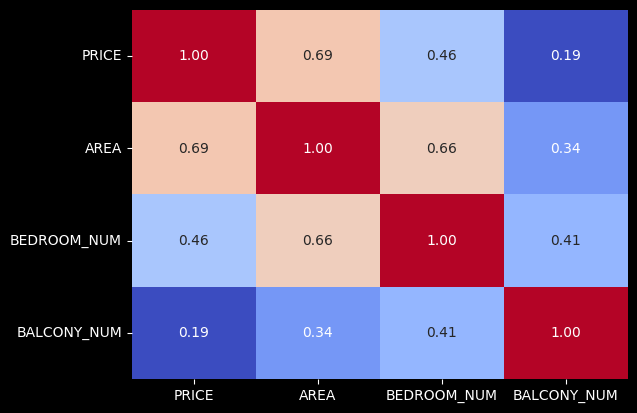

In [6]:
sns.heatmap(main_df.corr(numeric_only=True), cmap="coolwarm", cbar=False, annot=True, fmt=".2f")

### Encoding of categorical features

In [7]:
main_df["BEDROOM_NUM"] = main_df["BEDROOM_NUM"].apply(lambda x: x if x <= 5 else 99)
main_df["BALCONY_NUM"] = main_df["BALCONY_NUM"].apply(lambda x: x if x <= 4 else 99)

In [8]:
for col in cat_cols:
    if main_df[col].nunique() < 20:
        print(f"{col!r:>13}: {main_df[col].unique().tolist()}")
    else:
        print(f"{col!r:>13}: {main_df[col].nunique()}")

    'FURNISH': ['Furnished', 'Semifurnished', 'Unfurnished']
        'AGE': ['5-10 Year Old Property', '1-5 Year Old Property', 'Under Construction', '0-1 Year Old Property', '10+ Year Old Property']
'BEDROOM_NUM': [5.0, 1.0, 2.0, 3.0, 4.0, 99.0]
'BALCONY_NUM': [4.0, 1.0, 2.0, 3.0, 0.0]
  'FLOOR_NUM': ['low rise', 'mid rise', 'high rise']
     'FACING': ['North-East', 'East', 'North', 'South-East', 'South', 'West', 'South-West', 'North-West']
'LOCALITY_NAME': 116


In [9]:
ord_cols = {
    "FURNISH": ["Unfurnished", "Semifurnished", "Furnished"],
    "AGE": [
        "10+ Year Old Property",
        "5-10 Year Old Property",
        "1-5 Year Old Property",
        "0-1 Year Old Property",
        "Under Construction",
    ],
    "BEDROOM_NUM": [1, 2, 3, 4, 5, 99],
    "BALCONY_NUM": [0, 1, 2, 3, 4, 99],
    "FLOOR_NUM": ["low rise", "mid rise", "high rise"],
}
ohe_cols = ["FACING", "LOCALITY_NAME"]

### Encoding Pipeline

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", OrdinalEncoder(categories=list(ord_cols.values())), list(ord_cols.keys())),
        ("ohe", OneHotEncoder(sparse_output=False), ohe_cols),
    ],
    remainder="passthrough",
)

## Split Dataset

In [11]:
X = main_df.drop(columns=[target])
y = main_df[target]

# Preprocess the whole data and encode the categorical features
X_trf = pd.DataFrame(
    np.array(preprocessor.fit_transform(X)), columns=preprocessor.get_feature_names_out()
)

X_train, X_test, y_train, y_test = train_test_split(X_trf, y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, X_test.shape

((3239, 130), (810, 130))

<Axes: >

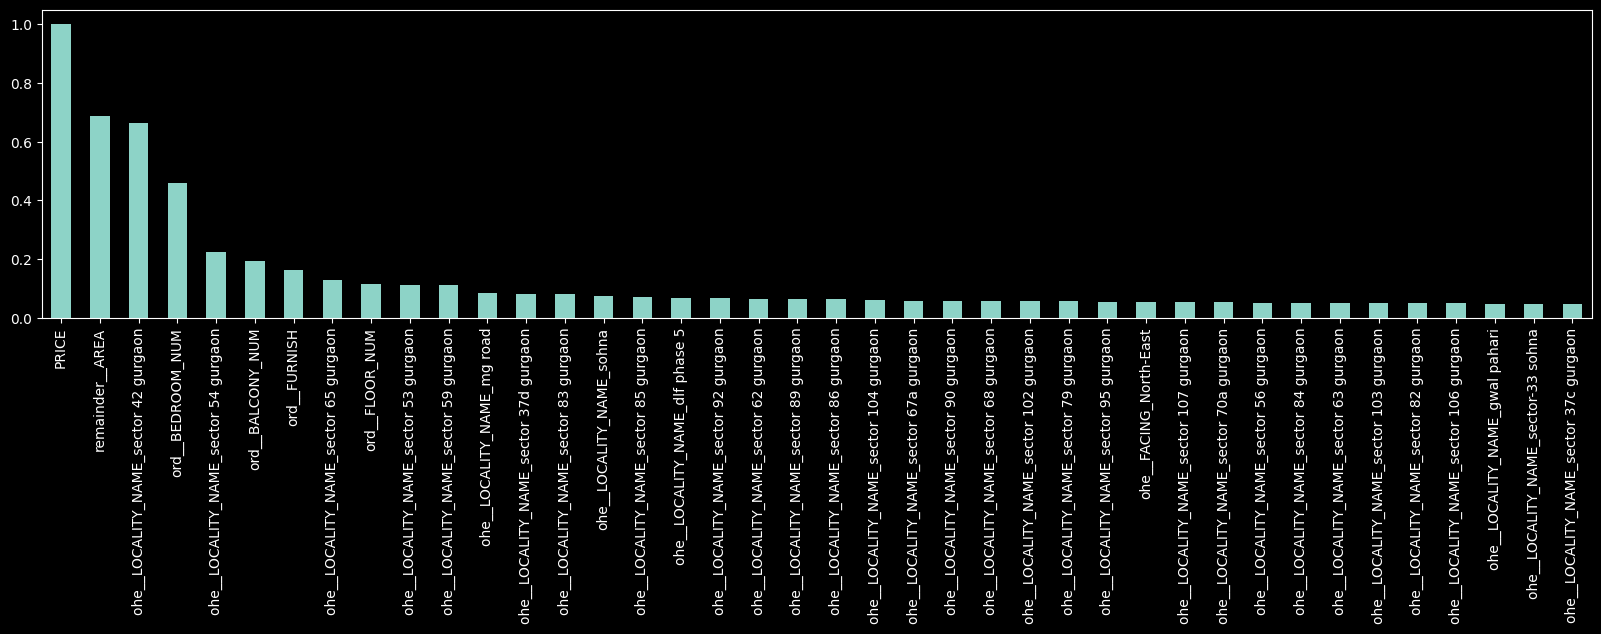

In [13]:
(
    pd.concat([X_trf, y.to_frame()], axis=1)
    .corr()["PRICE"]
    .abs()
    .sort_values(ascending=False)
    .head(40)
    .plot.bar(figsize=(20, 4))
)

In [14]:
def calc_scores(y_true, y_pred):
    print(f"mean_squared_error: {mean_squared_error(y_true, y_pred)}")
    print(f"mean_absolute_error: {round(mean_absolute_error(y_true, y_pred) / C.LAKH)} Lac")  # type: ignore

In [15]:
def create_model_pipe(estimator):
    return Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("model", estimator),
        ]
    )

## LinearRegression

In [16]:
lr_pipe = create_model_pipe(LinearRegression())
scores = cross_val_score(lr_pipe, X_train, y_train, scoring="r2", cv=5)
np.mean(scores)

-7.279285355882304e+23

In [17]:
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)
calc_scores(y_test, y_pred)

mean_squared_error: 8.200635295587054e+36
mean_absolute_error: 1805838938634 Lac


## Ridge

In [18]:
ridge_pipe = create_model_pipe(Ridge())
scores = cross_val_score(ridge_pipe, X_train, y_train, scoring="r2", cv=5)
np.mean(scores)

0.7650112106507237

In [19]:
ridge_pipe.fit(X_train, y_train)
y_pred = ridge_pipe.predict(X_test)
calc_scores(y_test, y_pred)

mean_squared_error: 197386000154531.47
mean_absolute_error: 63 Lac


## Lasso

In [20]:
lasso_pipe = create_model_pipe(Lasso())
scores = cross_val_score(lasso_pipe, X_train, y_train, scoring="r2", cv=5)
np.mean(scores)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.704e+16, tolerance: 2.252e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e+16, tolerance: 1.856e+14
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

0.7651257522505319

In [21]:
lasso_pipe.fit(X_train, y_train)
y_pred = lasso_pipe.predict(X_test)
calc_scores(y_test, y_pred)

mean_squared_error: 197398366821530.22
mean_absolute_error: 63 Lac


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+16, tolerance: 2.743e+14
  model = cd_fast.enet_coordinate_descent(


## ElasticNet

In [22]:
elastic_pipe = create_model_pipe(ElasticNet())
scores = cross_val_score(elastic_pipe, X_train, y_train, scoring="r2", cv=5)
np.mean(scores)

0.7306811829296744

In [23]:
elastic_pipe.fit(X_train, y_train)
y_pred = elastic_pipe.predict(X_test)
calc_scores(y_test, y_pred)

mean_squared_error: 314070363323107.5
mean_absolute_error: 74 Lac


## SVR

In [24]:
svr = create_model_pipe(SVR(kernel="rbf"))
scores = cross_val_score(svr, X_train, y_train, scoring="r2", cv=5)
np.mean(scores)

-0.08490346567729605

In [25]:
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
calc_scores(y_test, y_pred)

mean_squared_error: 1252528474434124.2
mean_absolute_error: 153 Lac


## RandomForestRegressor

In [26]:
rf = create_model_pipe(RandomForestRegressor())
scores = cross_val_score(rf, X_train, y_train, scoring="r2", cv=5)
np.mean(scores)

0.8415399281983191

In [27]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
calc_scores(y_test, y_pred)

mean_squared_error: 80088121806536.62
mean_absolute_error: 40 Lac


# Arree Wahh...!!

- I got `0.765` **r2_score** with `Ridge` and `63 Lac` **absolute error**.
- ⭐ I got `0.841` **r2_score** with `RandomForestRegressor` and `40 Lac` **absolute error**.